In [299]:
from ctypes import windll
#from sympy.physics.units.definitions.unit_definitions import ms
windll.shcore.SetProcessDpiAwareness(1)
import tkinter as tk

#由你的电脑的屏幕大小来决定

def get_screen_size():
    root = tk.Tk()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width, screen_height
screen_wide,screen_high=get_screen_size()

print(screen_wide,screen_high  )


2560 1600


1.读取数据

In [300]:
d1,d2=2500,2500
w1,w2=20,20



import pickle
import sys

def read_data(d1,d2,w1,w2):
    '''
    通过D,和W的大小来区分和读取数据，并返回四个数据结果。
    '''
    name=sys.path[0]+'\data\\'+'D='+str(d1)+'-'+str(d2)+'_W='+str(w1)+'-'+str(w2)+".bin"

    with open(name,'rb') as file:
        move_datas=pickle.load(file)
    
    return move_datas

mouse_move=read_data(d1,d2,w1,w2)

mouse_move中，顺序是：第几条轨迹，第几个时间点，当前的位置（t,x,y）

In [301]:
import numpy as np
for i in range(len(mouse_move)):
    print(np.shape(mouse_move[i]))
print(mouse_move[0][0])

(369869, 3)
(338215, 3)
(455161, 3)
(375102, 3)
(303763, 3)
(422544, 3)
(350565, 3)
(542340, 3)
(406945, 3)
(432088, 3)
(329158, 3)
(390198, 3)
(303364, 3)
(402685, 3)
(316220, 3)
(474894, 3)
(1690956901.6092992, 28.0, 802.0)


对单条轨迹进行判断，使用冒泡算法，当前后点相同时,t相同，删除轨迹点

In [302]:
def clean(mouse_move):
    new1=[]
    for i in range(len(mouse_move)):
        new2=[]
        t=-1
        x=-1
        y=-1
        for j in range(len(mouse_move[i])):
            
            if t==mouse_move[i][j][0] and x==mouse_move[i][j][1] and y==mouse_move[i][j][2]:
                t=mouse_move[i][j][0]
                x=mouse_move[i][j][1]
                y=mouse_move[i][j][2]
                continue
            else:
                t=mouse_move[i][j][0]
                x=mouse_move[i][j][1]
                y=mouse_move[i][j][2]
                new2.append(mouse_move[i][j])
        new1.append(new2)
    return new1

mouse_move=clean(mouse_move)

对于其中某些点进行处理，如果时间相同则，将其时间取前后时间的平均，

In [303]:
def average(mouse_move):
    new=[]
    for i in range(len(mouse_move)):
        new1=[]
        for j in range(len(mouse_move[i])-1):
            t=mouse_move[i][j][0]
            if mouse_move[i][j][0]==mouse_move[i][j+1][0]:
                r=1
                for k in range(j+1,len(mouse_move[i])-1):
                    if mouse_move[i][j][0]==mouse_move[i][k][0]:
                        r+=1
                        #print(k)
                #print('对于',mouse_move[i][j][0],'有',r,'个连续重复值')
                
                t0=mouse_move[i][j-1][0]
                t1=mouse_move[i][j+r][0]
                m=(t1-t0)/(r+1)
                t=t0+m*2
                
            new1.append([t,mouse_move[i][j][1],mouse_move[i][j][2]])
        new.append(new1)    
    
    for i in range(len(new)):
        for j in range(len(new[i])-1):
            if new[i][j][0]==new[i][j+1][0]:
                print('存在前后相同点：',i,j)
    
    return new

#mouse_move=average(mouse_move)



In [304]:
import numpy as np
t=[]
for i in range(len(mouse_move)):
    #print(np.shape(mouse_move[i]))
    #print(mouse_move[i][-1][0]-mouse_move[i][0][0])
    t.append(mouse_move[i][-1][0]-mouse_move[i][0][0])

print('平均时间为',np.mean(t))

平均时间为 1.1458342224359512


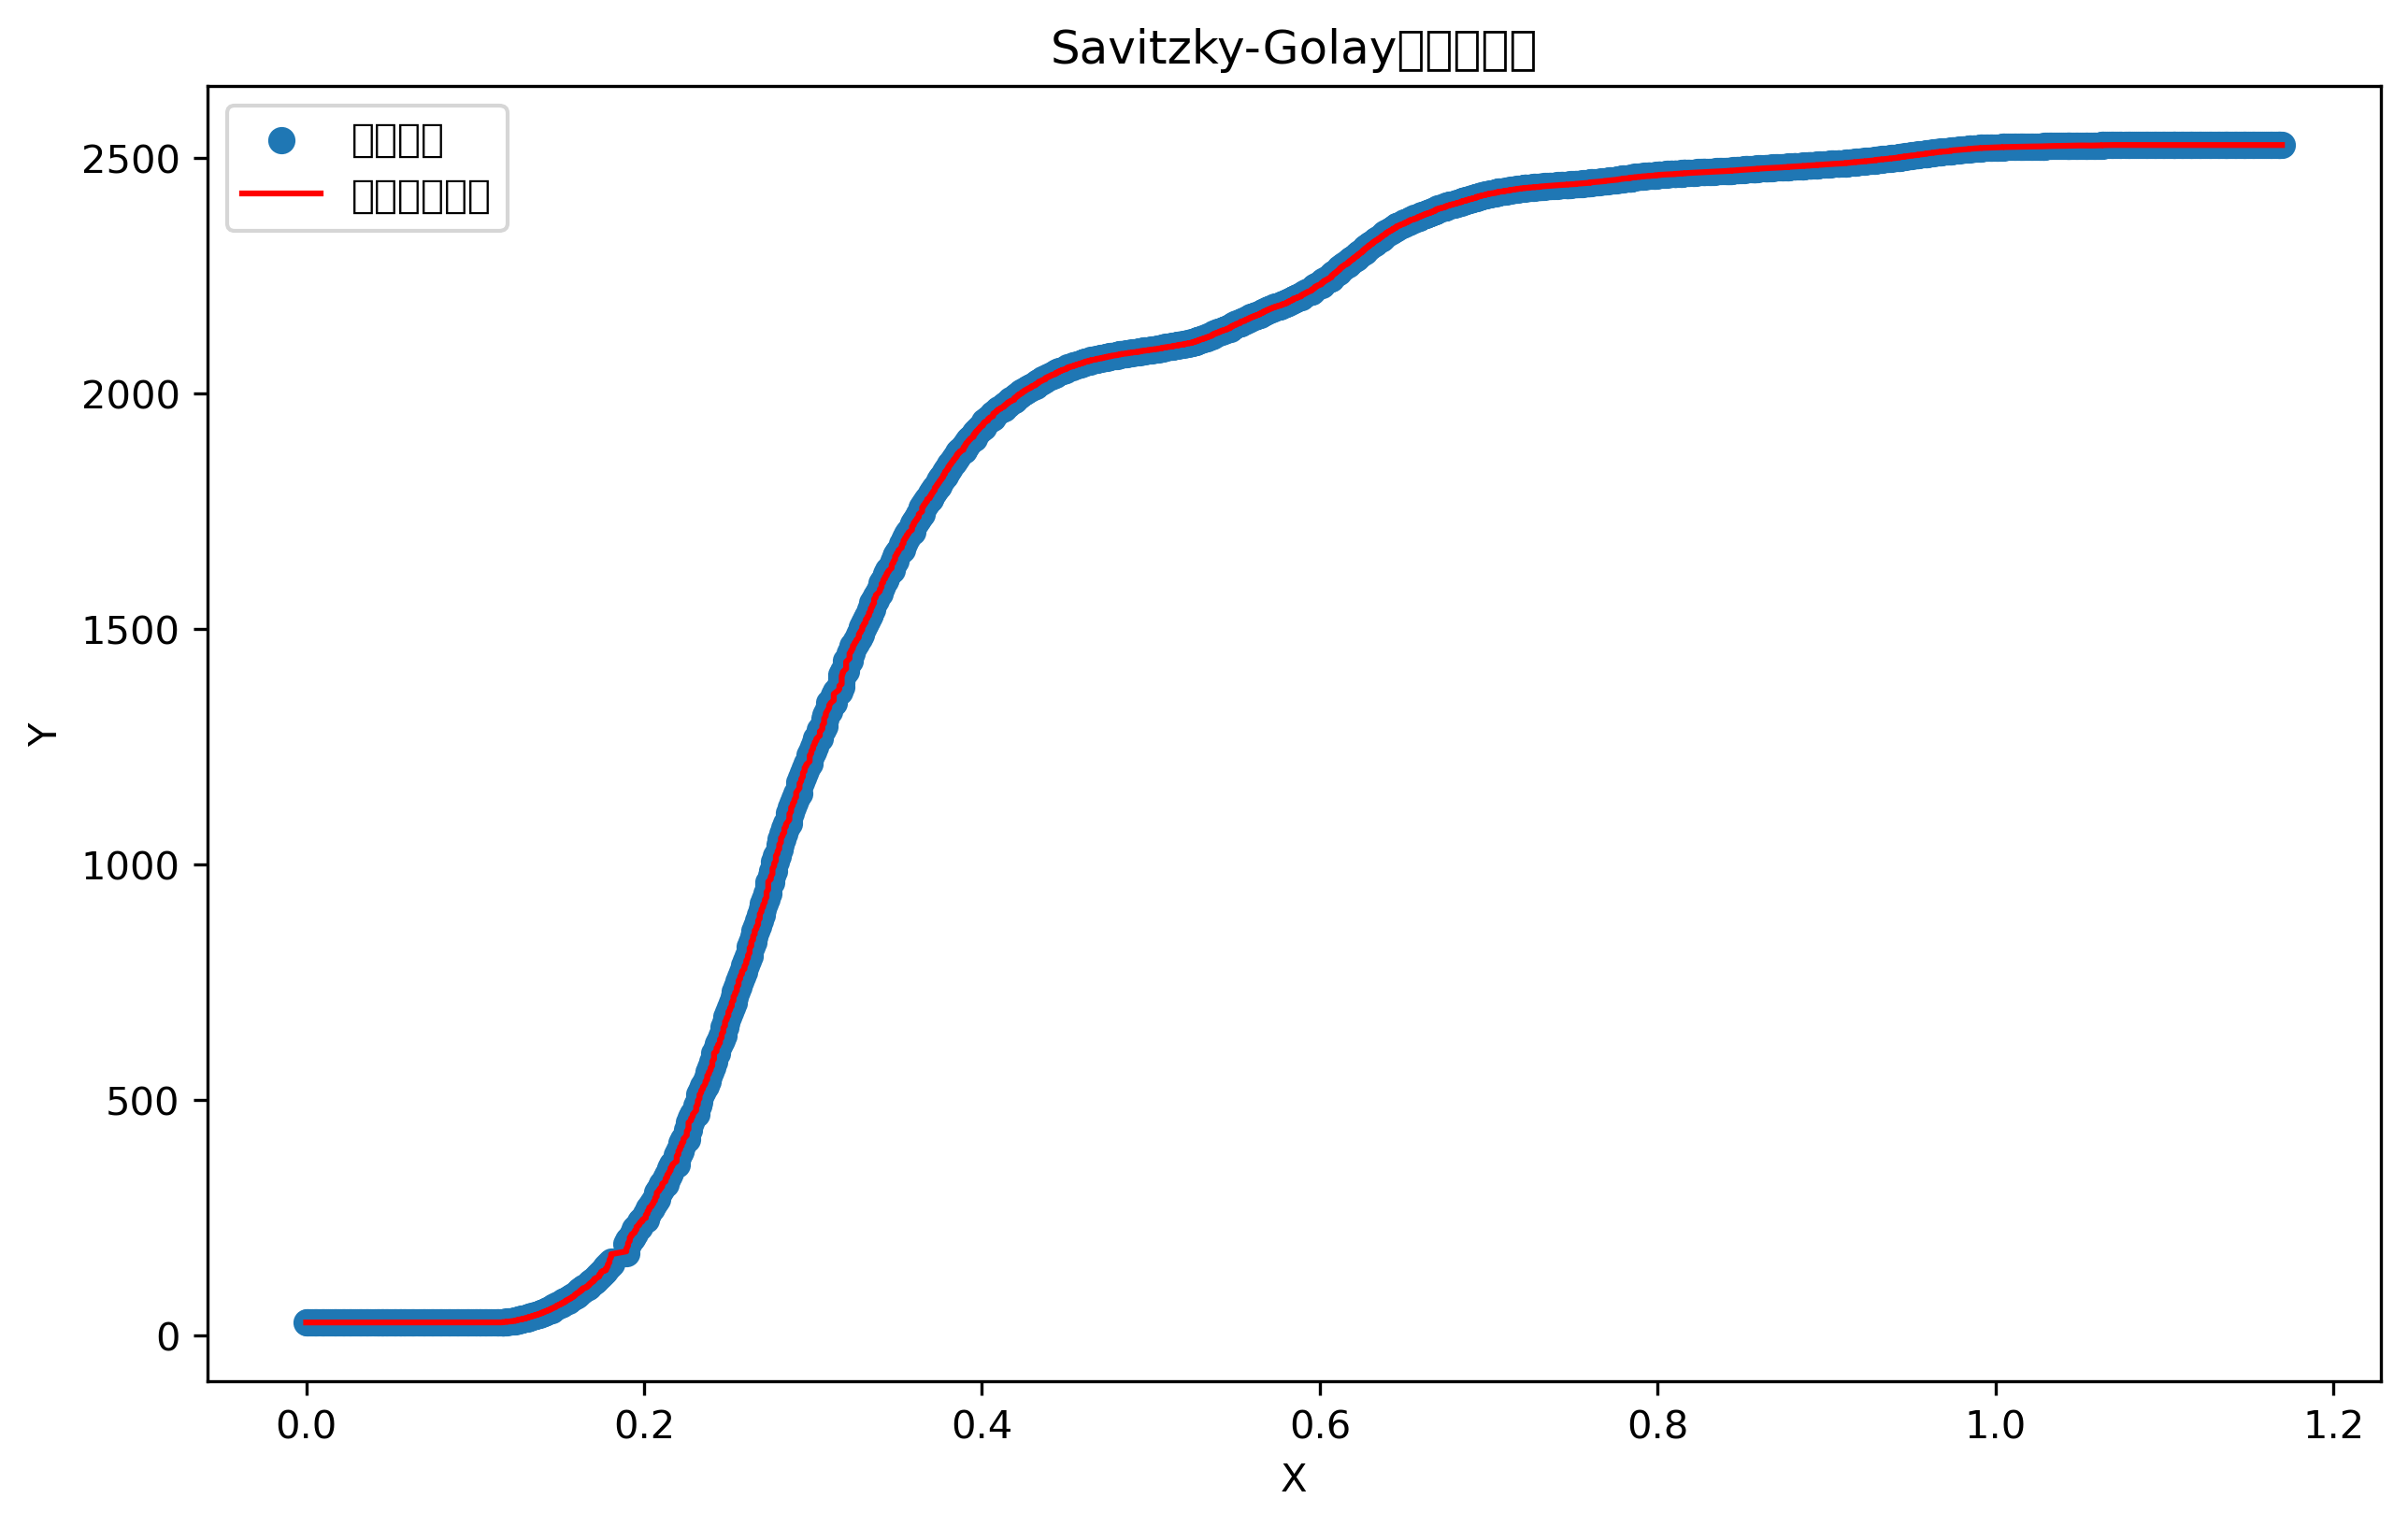

In [305]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

T=[]
X=[]
Y=[]
k=0
for i in range(len(mouse_move[k])):
    #print(mouse_move[0][i])
    T.append(mouse_move[k][i][0]-mouse_move[k][0][0])
    X.append(mouse_move[k][i][1])
    Y.append(mouse_move[k][i][2])   

# 使用Savitzky-Golay滤波器平滑数据
window_size = 50  # 窗口大小
poly_order = 8    # 多项式阶数
X_smoothed = savgol_filter(X, window_size, poly_order)
Y_smoothed = savgol_filter(Y, window_size, poly_order)

# 绘制原始数据和平滑后的数据
plt.figure(figsize=(10, 6),dpi=300)
plt.scatter(T, X, label='原始数据')
plt.plot(T, X_smoothed, label='平滑后的数据',color='red')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Savitzky-Golay滤波器示例')
plt.show()


#进行y方向平滑处理

In [306]:
import numpy as np

# 读取数据
X=X_smoothed
Y=Y_smoothed

s=0
S=[0,]#点在轨迹上的位置
for i in range(1,len(X)):
    s+=np.sqrt((X[i]-X[i-1])**2+(Y[i]-Y[i-1])**2)
    S.append(s)
    
    


进行滤波处理

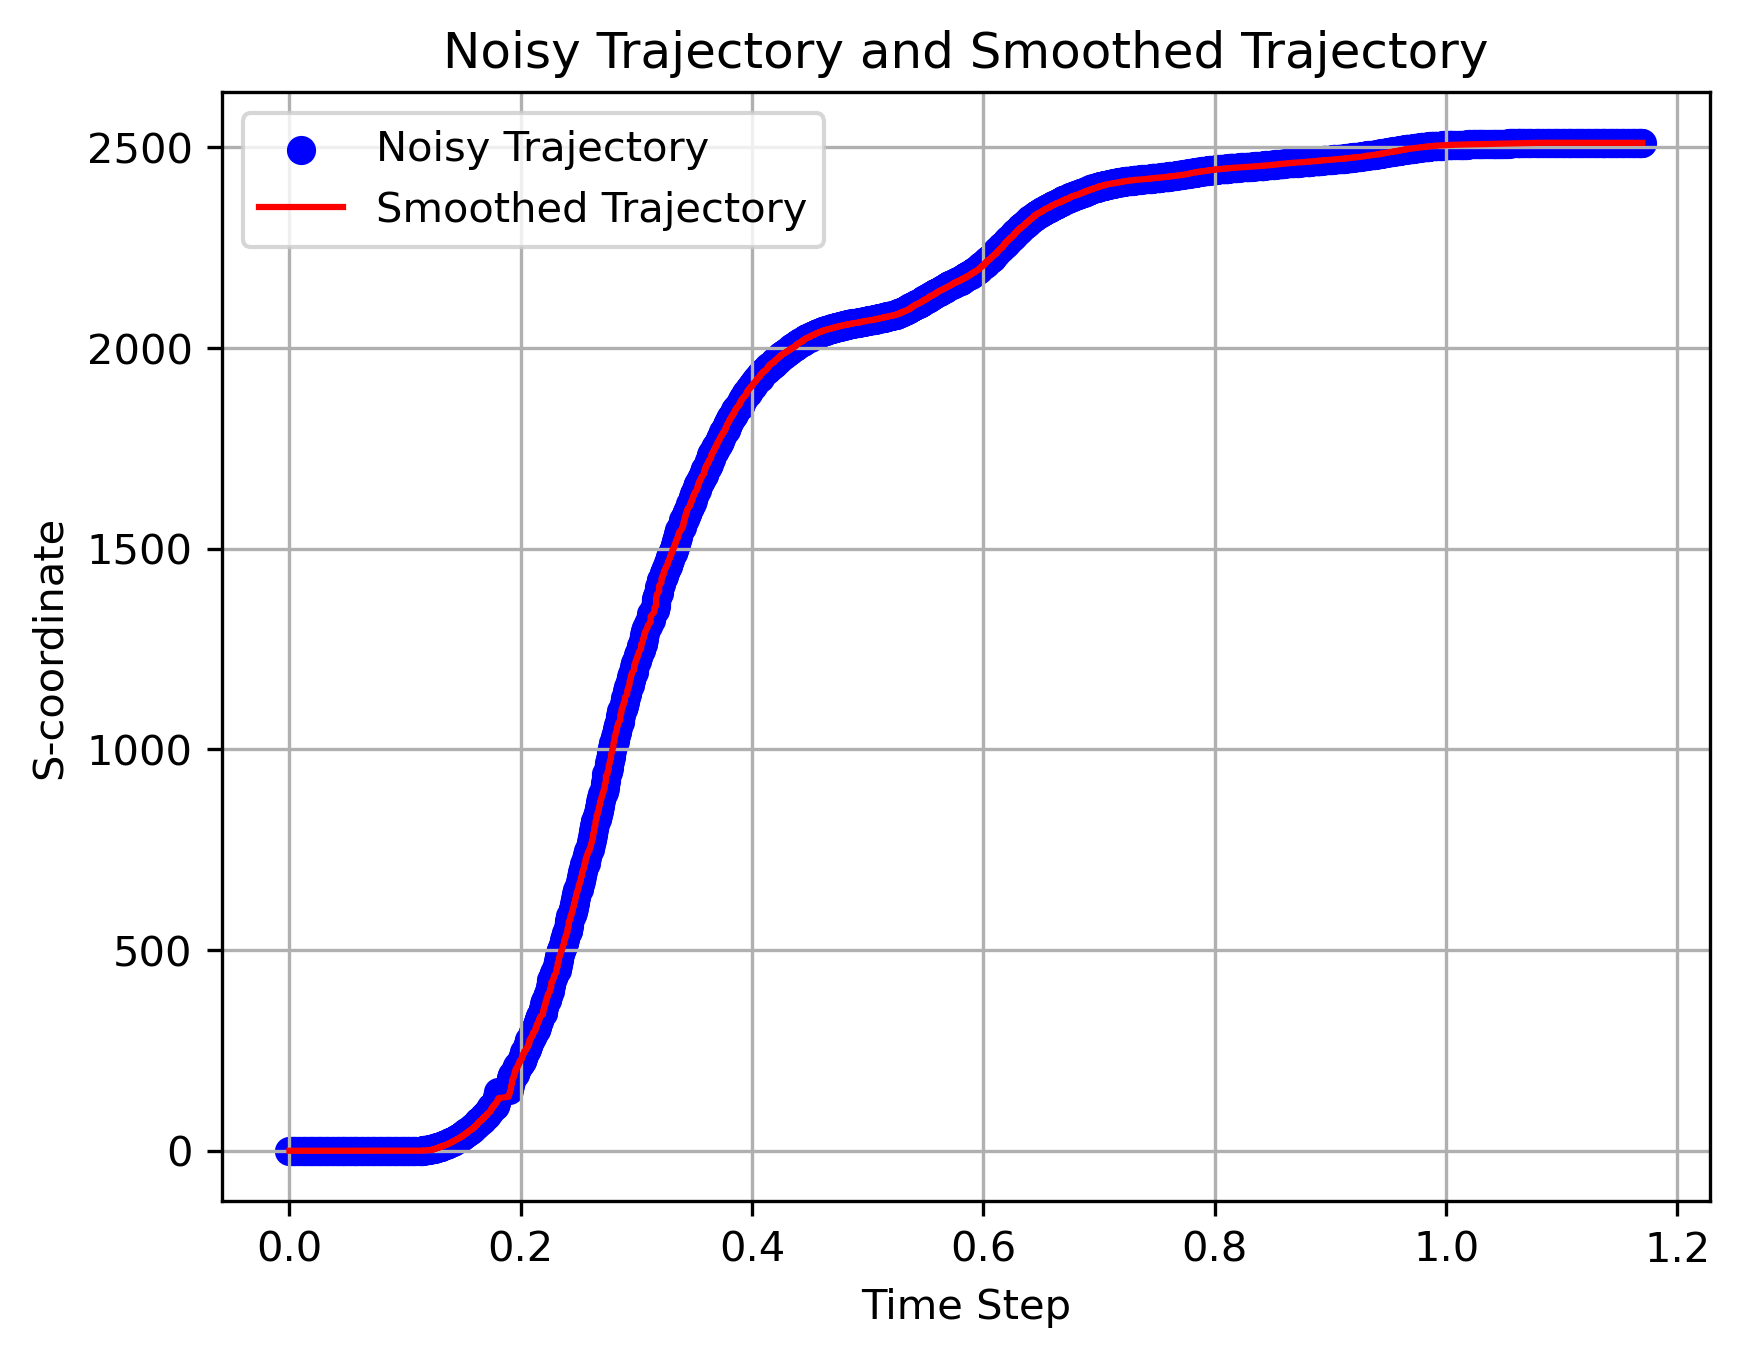

In [307]:
import random
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

def apply_kalman_filter(trajectory, measurement_noise, process_noise):
    # 初始化Kalman滤波器
    kf = KalmanFilter(dim_x=2, dim_z=1)
    
    # 设置状态转移矩阵F，这里假设每一步状态都是从上一步演化而来
    kf.F = np.array([[1., 1.],
                     [0., 1.]])
    
    # 设置测量矩阵H，这里是一个1x2的矩阵，表示从状态空间到测量空间的映射
    kf.H = np.array([[1., 0.]])
    
    # 设置测量噪声矩阵R，这里假设测量噪声是高斯分布
    kf.R = measurement_noise**2
    
    # 设置过程噪声矩阵Q，这里假设过程噪声也是高斯分布
    kf.Q = np.array([[process_noise**2, 0.],
                     [0., process_noise**2]])
    
    # 初始化状态向量x和协方差矩阵P
    kf.x = np.array([trajectory[0][0], 0.])  # 初始位置和速度都设为0
    kf.P = np.eye(2)  # 初始协方差矩阵设为单位矩阵
    
    # 用Kalman滤波器对轨迹数据进行处理
    smoothed_trajectory = [kf.x[0]]  # 用于存储平滑后的轨迹
    for measurement in trajectory[1:]:
        kf.predict()  # 预测下一时刻状态
        kf.update(measurement[1])  # 更新状态，这里只有Y坐标是测量值，X坐标由状态转移矩阵预测得到
        smoothed_trajectory.append(kf.x[0])
    
    return smoothed_trajectory

trajectory_with_noise=[]
for i in range(len(T)):
    trajectory_with_noise.append((T[i],S[i]))
# 设置Kalman滤波器的测量噪声和过程噪声
measurement_noise = 15
process_noise = 0.1

# 使用Kalman滤波器对轨迹数据进行降噪处理
S_smoothed = apply_kalman_filter(trajectory_with_noise, measurement_noise, process_noise)

plt.figure(dpi=300)
plt.scatter(T,S, c='b', label='Noisy Trajectory', )
plt.plot(T, S_smoothed, c='r', label='Smoothed Trajectory')
plt.title('Noisy Trajectory and Smoothed Trajectory')
plt.xlabel('Time Step')
plt.ylabel('S-coordinate')
plt.legend()
plt.grid()
plt.show()


使用T与S的关系求V

2082 2082 2082


C:\Users\liuyu\AppData\Local\Temp\ipykernel_26000\3769212133.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  velocities.append((distance[i+1]-distance[i]) / (time[i+1] - time[i]))


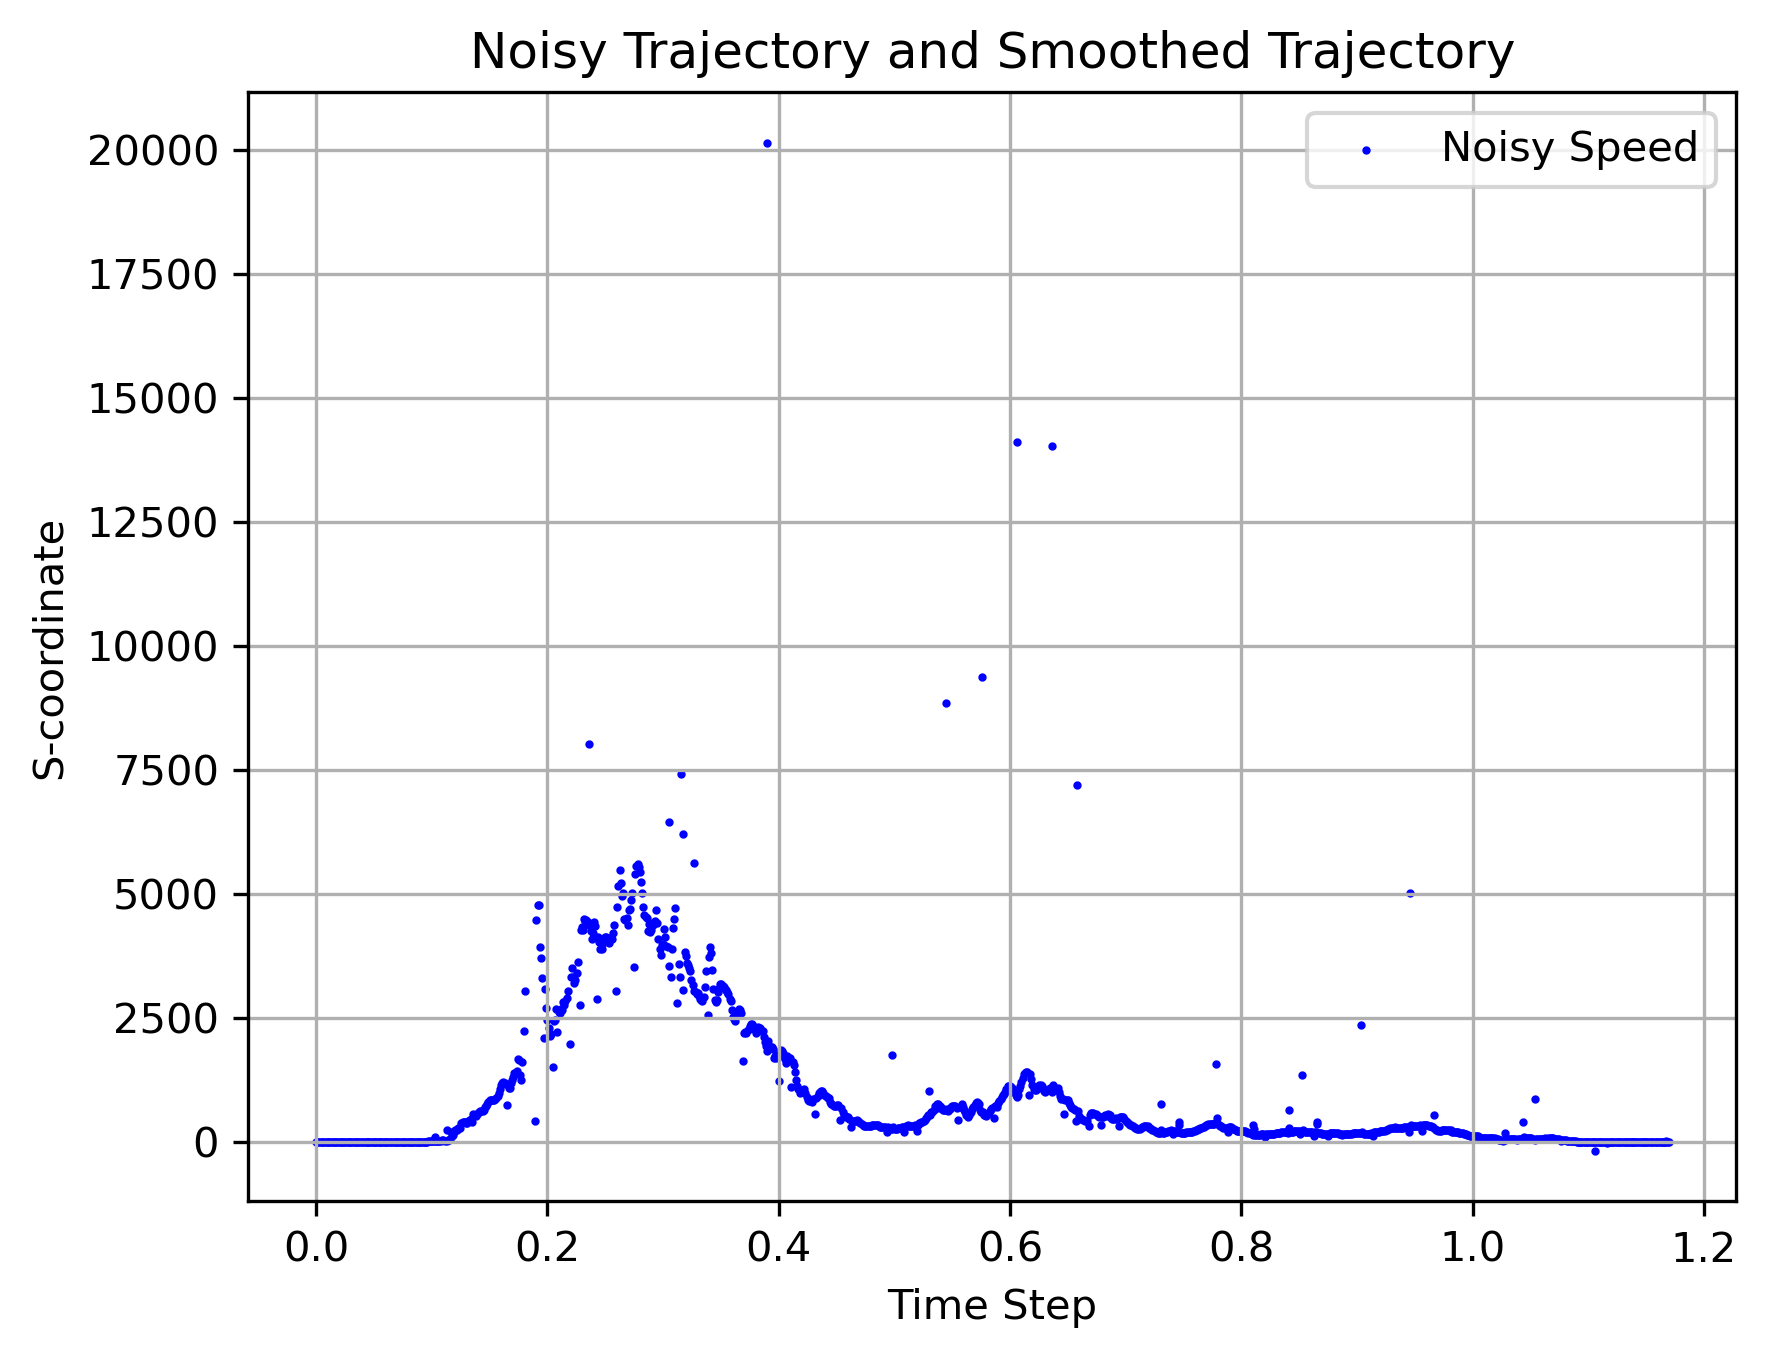

In [308]:
#已知T，S，S_smooth
#求S的一阶导数
def calculate_velocity(time, distance):
    """
    计算速度
    :param time: 时间列表（单位：秒）
    :param distance: 距离列表（单位：米）
    :return: 速度列表（单位：米/秒）
    """
    velocities = [0,]
    for i in range(len(time) - 1):
         velocities.append((distance[i+1]-distance[i]) / (time[i+1] - time[i]))
    return velocities


# 计算速度
V = calculate_velocity(T, S_smoothed)
print(len(V), len(T), len(S))

# 输出速度列表
plt.figure(dpi=300)
plt.scatter(T,V, c='b', label='Noisy Speed', s=1)
plt.title('Noisy Trajectory and Smoothed Trajectory')
plt.xlabel('Time Step')
plt.ylabel('S-coordinate')
plt.legend()
plt.grid()
plt.show()


In [309]:
import random
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

trajectory_with_noise=[]
for i in range(len(T)):
    trajectory_with_noise.append((T[i],V_smoothed[i]))
# 设置Kalman滤波器的测量噪声和过程噪声
measurement_noise = 10
process_noise = 0.1

# 使用Kalman滤波器对轨迹数据进行降噪处理
V_smoothed_1 = apply_kalman_filter(trajectory_with_noise, measurement_noise, process_noise)

plt.figure(dpi=300)
#plt.scatter(T,V_smoothed, c='b', label='Noisy Trajectory', s=1)
plt.scatter(T, V_smoothed_1, c='r', label='Smoothed Trajectory',s=1)
plt.title('Noisy Trajectory and Smoothed Trajectory')
plt.xlabel('Time Step')
plt.ylabel('S-coordinate')
plt.legend()
plt.grid()
plt.show()


IndexError: list index out of range